<a href="https://colab.research.google.com/github/SiliconJackets/sscs-ose-code-a-chip.github.io/blob/main/VLSI25/submitted_notebooks/Retiming.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamically Pipelined Arithmetic Modules for Adaptive Critical Path Optimization

```
Copyright 2025 SiliconJackets @ Georgia Institute of Technology
SPDX-License-Identifier: Apache-2.0
```

This project includes a library of arithmetic modules, that can be dynamically pipelined to alleviate timing closure during synthesis. The adjustment of the pipeline stages in the arithmetic modules follows an ad-hoc decision making logic that resembles a retiming engine. The arithmetic modules have been tested using the [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/) platform on the [open source SKY130 PDK](https://github.com/google/skywater-pdk/).

|Name|Affiliation| Email |IEEE Member|SSCS Member|
|:--:|:----------:|:----------:|:----------:|:----------:|
|Sowmya Janapati|Georgia Institute of Technology| jsowmya@gatech.edu|No|No|
|Ethan Huang|Georgia Institute of Technology|ethanhuang@gatech.edu|No|No|
|Athanasios Moschos|Georgia Institute of Technology|amoschos@gatech.edu|No|No|
|Shengxi Shou|Georgia Institute of Technology|s.shou@gatech.edu|No|No|
|Anson Chau|Georgia Institute of Technology|achau36@gatech.edu|No|No|
|Edmund Chen|Georgia Institute of Technology|echen373@gatech.edu|No|No|
|Nealson Li|Georgia Institute of Technology|nealson@gatech.edu|Yes|Yes|
|Zachary Ellis|Georgia Institute of Technology|zellis7@gatech.edu|Yes|Yes|

This notebook demonstrates an ad-hoc retiming engine that takes advantage of arithmetic modules with dynamic pipelines stages to alleviate timing closure on an L2 normilization filter. Our demonstration uses open-source tools and PDKs. We open-source both our decision making algorithm for retiming, as well as the library with the pipelined modules. Vector norms, like L2, are fundamental and effective tools for measuring, comparing, and manipulating data with precision and are useful among other domains, in machine learning (ML). Our arithmetic module library aims to contribute to the open-source hardware design community to enable more efficient ML applications. Moreover, our open-source custom retiming algorithm can serve as a reference point for understanding the principles that govern the process of retiming in digital design. This submission is completed by members of SiliconJackets. We are a student run organization at Georgia Tech that introduces students to semiconductor design, verification, and implementation through a large collaborative project. We are hoping to use this notebook as an example for future members of the club.








## Introduction
---


This notebook will initially provide an overview of the pipelined arithmetic modules and their structure, as well as of an L2 digital design that utilizes them. We will then proceed to explain the decision making principles behind our ad-hoc retiming engine algorithm. Lastly, to demonstrate the effectiveness of our ad-hoc retiming algorithm and our pipelined library, we will synthesize the L2 design with challenging clock frequencies to showcase the advantages of our library in timing closure. The synthesis will be performed using the [Yosys](https://github.com/The-OpenROAD-Project/yosys) synthesis tool that is intergrated in the [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/) project. Timing analysis will use the [OpenSTA](https://github.com/The-OpenROAD-Project/OpenSTA) static timing analysis engine of OpenROAD, on the pre-PnR Verilog netlist that was generated by Yosys. The standard cells ustilized in the netlist are provided by the open-source [SKY130 PDK](https://github.com/google/skywater-pdk/).

## Arithmetic Modules Library
---

### Multiplier
The multiplier design can perform product computations essential for vector operations, matrix transformations, and filtering tasks. It is scalable, as it supports operands and products of different bit widths. With its pipeline structure, it can enhance performance in DSP and ML workloads.


<p align="center">
  <img src="https://github.com/SiliconJackets/Retiming/blob/main/schematics/Multiplier_schematic.png?raw=true" width="500">
</p>

### Divider
The divider enables precise quotient calculations, critical for normalization and scaling operations in DSP and ML. Its pipelined architecture can allow for low-latency divisions in deeply nested arithmetic expressions.

### Square Root
This module computes square roots precisely, a fundamental operation in norm and distance calculations. Its efficient pipelining can support iterative approximation methods, making it well-suited for real-time applications in ML (e.g., inference).

### Adder Tree
This module is designed to efficiently sum multiple operands. It is crucial for dot product computations and summation operations. By balancing depth and fan-in, the pipelined structure minimizes timing bottlenecks in highly parallel arithmetic logic.

### Adder Subtractor
This versatile unit can perform addition and subtraction, and it is often used in differential and multiply-accumulate operations. These arithmetic operations are integral to many filtering and feature extraction routines.

### Pipeline Stage

1.   List item
2.   List item






<p align="center">
  <img src="https://github.com/SiliconJackets/Retiming/blob/main/schematics/pipeline%20schematic.png?raw=true" width="500">
</p>




### L2 Norm

The L2 norm design computes the Euclidean distance between vector elements, serving as a critical component in applications requiring magnitude comparison, such as filtering, clustering, and anomaly detection. In machine learning, the L2 norm is frequently used in loss functions (e.g., mean squared error), regularization techniques, and similarity computations in clustering algorithms and neural network optimization. We use in our project the L2 norm digital design, to demonstrate the abilities of our dynamically retimed arithmetic module library and how it can be efficiently adjusted to help timing closure of modules with big combinational data paths.

<p align="center">
  <img src="https://github.com/SiliconJackets/Retiming/blob/main/schematics/top_schematic.png?raw=true" width="500">
</p>


### Pipelined Arithmetic Module Library Advantages

Adjustable pipelining within arithmetic modules can add significant flexibility in different aspects of the digital design.
- **Improved Timing Closure:** Pipeline stages can be dynamically repositioned across the datapath to mitigate critical paths, allowing better timing convergence during synthesis and place-and-route.
- **Design Portability and Reusability:** Modular, reconfigurable pipelining enables the arithmetic units to be reused across designs with varying frequency and performance constraints, reducing engineering effort.
- **Area-Performance Trade-offs:** Customizing pipeline depth enables designers to balance area and speed based on system-level requirements, facilitating efficient exploration of design space. The arithmetic modules we provide in this library require special handling of the output on the designer's end, if more than one pipeline stages are enabled.
- **Retiming Engine Integration:** The arithmetic modules in this library are compatible with custom retiming engines (e.g., like the one we provide in this repo), thus offering automated optimization paths that resemble the flexibility of high-level synthesis, while still preserving RTL-level control.
- **Educational and Research Value:** Configurable pipelining demonstrates fundamental design principles in a hands-on manner, aiding both in learning and evaluating experimental architectures.

## Ad-hoc Retiming Engine
---

### Pipeline-stage Decision Making Algorithm
The engine interprets each arithmetic module as an array of potential pipeline stages whose enable pattern is stored in a pipeline-stage mask. A ‘1’ denotes an enabled pipeline stage; the number of zeros between successive ‘1’s is the combinational path data must cross in one cycle. To ease a setup violation, we shorten that distance: if the critical path goes from launch flip-flop (startpoint) to capture flip-flop (endpoint), nudging toward the startpoint shifts the endpoint’s ‘1’ one bit right, while nudging toward the endpoint shifts the startpoint’s ‘1’ one bit left, bringing the latches one stage closer.

Input to Register: input fixed (only right shifts allowed)
- `Output <- 0101001100 <- Input` to `Output <- 0101001010 <- Input`

Register to Output: output fixed (only left shifts allowed)
- `Output <- 0101001100<- Input` to `Output <- 1001001010 <- Input`

Register to Register: both ends movable (choose left or right, determined by the algorithm below)
- `Output <- 001000100 <- Input` to `Output <- 001001000 <- Input` (left)
- `Output <- 001000100 <- Input` to `Output <- 000100100 <- Input` (right)

An illustartion of our algorithm's operation can be seen in the diagram below.
<p align="center">
  <img src="https://github.com/SiliconJackets/Retiming/blob/main/schematics/retime_optimized.gif?raw=true" width="850">
</p>

The engine first runs a synthesis, followed by a pre-pnr STA at the current clock period. The critical paths are sorted by worst negative slack (WNS), and we iterate through all the paths. For each path, the engine also finds its adjacent paths, giving a three-arc local view of available timing margins.

If this local configuration has not been encountered before, the engine enters deterministic mode. Here, the slack on the two adjacent arcs is compared; the engine shifts whichever flip-flop (startpoint or endpoint) sits on the arc with the larger slack. The adjacent arc slack worsens, while the critical path slack improves.

If the same configuration reappears—detected through a hash of the entire violated-path set—the engine assumes it is trapped in a local minimum and switches to a Monte-Carlo mode in which the direction of the nudge is chosen at random. This step lets the search escape oscillatory patterns from the greedy deterministic algorithm. A per-run threshold terminates the search for the present clock period if we have encountered the same hash multiple times.

The flowchart shows the high-level algorithm described above:
<p align="center">
  <img src="https://github.com/SiliconJackets/Retiming/blob/main/schematics/RetimingFlowWhiteBackground.png?raw=true" width="800">
</p>

The new pipeline stage mask is appended to the `PIPELINE_STAGE_MASK` local-param branch associated with the specific instance ID of the modified module. The entire synthesis–STA flow is then re-executed. Iterations continue until (i) all setup paths are non-negative, (ii) a user-defined iteration limit is reached, or (iii) the kill flag is raised. If the limit is reached without closure, the script can optionally widen the clock period by a fixed increment and restart; otherwise, it exits and reports the final status.

The flowchart shows the top level flow described above:
<p align="center">
  <img src="https://github.com/SiliconJackets/Retiming/blob/main/schematics/RetimeTopLevel.png?raw=true" width="700">
</p>

### Implementation
We have evaluated our custom retiming engine using the [Yosys](https://github.com/The-OpenROAD-Project/yosys) synthesis tool that has integration with the [OpenLane](https://github.com/The-OpenROAD-Project/OpenLane/) project.




## Try Our Retiming Algorithm Yourself

In [1]:
%%capture
#@title Install Dependencies {display-mode: "form"}
#@markdown Click the ▷ button to setup the simulation environment.

#@markdown Main components we will install

#@markdown *   openlane2 : An open-source automated RTL-to-GDSII flow for digital ASIC design, built on top of tools like OpenROAD and Yosys, optimized for Sky130 and other open PDKs.

import os
import sys
import shutil
import subprocess
import IPython

os.environ["LOCALE_ARCHIVE"] = "/usr/lib/locale/locale-archive"

if "google.colab" in sys.modules:
    if shutil.which("nix-env") is None:
        !curl -L https://nixos.org/nix/install | bash -s -- --daemon --yes
        !echo "extra-experimental-features = nix-command flakes" >> /etc/nix/nix.conf
        !killall nix-daemon
else:
    if shutil.which("nix-env") is None:
        raise RuntimeError("Nix is not installed!")

os.environ["PATH"] = f"/nix/var/nix/profiles/default/bin/:{os.getenv('PATH')}"

openlane_version = "version-2.1"

if openlane_version == "latest":
    openlane_version = "main"

pdk_root = "~/.volare"

pdk_root = os.path.expanduser(pdk_root)

pdk = "sky130"

openlane_ipynb_path = os.path.join(os.getcwd(), "openlane_ipynb")

display(IPython.display.HTML("<h3>Downloading OpenLane…</a>"))


TESTING_LOCALLY = False
!rm -rf {openlane_ipynb_path}
!mkdir -p {openlane_ipynb_path}
if TESTING_LOCALLY:
    !ln -s {os.getcwd()} {openlane_ipynb_path}
else:
    !curl -L "https://github.com/efabless/openlane2/tarball/{openlane_version}" | tar -xzC {openlane_ipynb_path} --strip-components 1

try:
    import tkinter
except ImportError:
    if "google.colab" in sys.modules:
        !sudo apt-get install python-tk

try:
    import tkinter
except ImportError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to import the <code>tkinter</code> library for Python, which is required to load PDK configuration values. Make sure <code>python3-tk</code> or equivalent is installed on your system.</a>'
        )
    )
    raise e from None


display(IPython.display.HTML("<h3>Downloading OpenLane's dependencies…</a>"))
try:
    subprocess.check_call(
        ["nix", "profile", "install", ".#colab-env", "--accept-flake-config"],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install binary dependencies using Nix…</h3>'
        )
    )

display(IPython.display.HTML("<h3>Downloading Python dependencies using PIP…</a>"))
try:
    subprocess.check_call(
        ["pip3", "install", "."],
        cwd=openlane_ipynb_path,
    )
except subprocess.CalledProcessError as e:
    display(
        IPython.display.HTML(
            '<h3 style="color: #800020";>❌ Failed to install Python dependencies using PIP…</h3>'
        )
    )
    raise e from None

display(IPython.display.HTML("<h3>Downloading PDK…</a>"))
import volare

volare.enable(
    volare.get_volare_home(pdk_root),
    pdk,
    open(
        os.path.join(openlane_ipynb_path, "openlane", "open_pdks_rev"),
        encoding="utf8",
    )
    .read()
    .strip(),
)

sys.path.insert(0, openlane_ipynb_path)
display(IPython.display.HTML("<h3>⭕️ Done.</a>"))

import logging

# Remove the stupid default colab logging handler
logging.getLogger().handlers.clear()

In [2]:
%%capture

#@title Download Our Pipelined IP Library and Scripts

#@markdown Click the ▷ button to download the rtl files.
#@markdown The files will be downloaded to the SytolicArray directory
#@markdown the file structure is described below:

#@markdown UPDATE THE FILE LIST PROPERLY
#@markdown *   Retiming/Design
#@markdown    *  AdderTree/
#@markdown       *   `AdderTree.sv`        : Adder Tree design for N - inputs
#@markdown    *  Adder_Subtractor/
#@markdown       *   `adder_subtractor.sv` : N bit width adder/subtractor design
#@markdown    *  Divider/
#@markdown       *   `divider.sv`          : N bit width divider design
#@markdown    *  Multiplier/
#@markdown       *   `array_multiplier.sv` : N bit width array multiplier design
#@markdown    *  SquareRoot/
#@markdown       *   `squareroot.sv`       : N bit width square root design
#@markdown    *  Top/
#@markdown       *   `top.sv`              : L2 Norm Top Level
#@markdown    *  Testbenches/              : Testbenches for each module
#@markdown    *  Scripts/                  : Retiming and helper scripts

%cd /content/
!rm -rf Retiming
!git clone https://github.com/SiliconJackets/Retiming.git Retiming
!rm -rf Retiming/openlane2


### Retiming Optimization of a 4-Input Sum of Squares Circuit

To demonstrate the performance improvement enabled by our retiming algorithm in digital circuit designs, we apply retiming to a 4-input sum of squares circuit.

This circuit computes the expression:
$$
\text{Output} = A^2 + B^2 + C^2 + D^2
$$

Retiming helps balance the logic delay across different stages of the circuit by repositioning the registers, which can reduce the overall critical path and improve clock frequency.

The original datapath consists of four parallel multiplier units which squares each input, followed by an adder tree that sums the squared values. Without retiming, the longest combinational path may create timing bottlenecks, limiting performance.

We apply our retiming algorithm to find the best distribution of pipeline stages in each multiplier and adder tree such that all paths between registers have a more uniform delay. This allows the circuit to operate at a higher clock frequency, improving throughput without changing its functionality.

The demonstration involves the following steps:

1. Install the software dependencies
2. Download the python and verilog files of our design
3. Run the script to see that with proper distribution of pipeline stages result in design meeting the timing which it was not able to meet earlier.
4. Compare the clock frequency for baseline pipeline mask configuration and optimized pipeline configuration


/content/Retiming/Scripts


──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

──────────────────────────────────────── Static Timing Analysis (Pre-PnR) ─────────────────────────────────────────

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┓
┃                      ┃       ┃       ┃      ┃       ┃ of   ┃       ┃      ┃       ┃      ┃ of    ┃      ┃       ┃
┃                      ┃       ┃ Reg   ┃      ┃       ┃ whi… ┃       ┃ Reg  ┃       ┃      ┃ which ┃      ┃       ┃
┃                      ┃ Hold  ┃ to    ┃      ┃ Hold  ┃ reg  ┃ Setup ┃ to   ┃       ┃ Set… ┃ reg   ┃ Max  ┃ Max   ┃
┃                      ┃ Worst ┃ Reg   ┃ Hold ┃ Vio   ┃ to   ┃ Worst ┃ Reg  ┃ Setup ┃ Vio  ┃ to    ┃ Cap  ┃ Slew  ┃
┃ Corner/Group         ┃ Slack ┃ Paths ┃ TNS  ┃ Count ┃ reg  ┃ Slack ┃ Pat… ┃ TNS   ┃ Cou… ┃ reg   ┃ Vio… ┃ Viol… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━┩
│ Overall              │ 0.39… │ 0.39… │ 0.0… │ 0     │ 0    │ -0.8… │ -0.… │ -3.3… │ 12   │ 8     │ 1    │ 0     │
│ nom_tt_025C_1v80     │ 0.61… │ 0.61… │ 0.0… │ 0     │ 0    │ 1.78… │ 2.6… │ 0.00… │ 0    │ 0     │ 1    │ 0     │
│ nom_ss_100C_1v60     │ 1.24… │ 1.24… │ 0.0… │ 0     │ 0    │ -0.8… │ -0.… │ -3.3… │ 12   │ 8     │ 1    │ 0     │
│ nom_ff_n40C_1v95     │ 0.39… │ 0.39… │ 0.0… │ 0     │ 0    │ 2.80… │ 3.6… │ 0.00… │ 0    │ 0     │ 1    │ 0     │
└──────────────────────┴───────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┘

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃                      ┃ Hold     ┃ Reg to   ┃          ┃          ┃ of which  ┃ Setup    ┃           ┃          ┃           ┃ of which ┃           ┃          ┃
┃                      ┃ Worst    ┃ Reg      ┃          ┃ Hold Vio ┃ reg to    ┃ Worst    ┃ Reg to    ┃ Setup    ┃ Setup Vio ┃ reg to   ┃ Max Cap   ┃ Max Slew ┃
┃ Corner/Group         ┃ Slack    ┃ Paths    ┃ Hold TNS ┃ Count    ┃ reg       ┃ Slack    ┃ Reg Paths ┃ TNS      ┃ Count     ┃ reg      ┃ Violatio… ┃ Violati… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Overall              │ 0.3949   │ 0.3949   │ 0.0000   │ 0        │ 0         │ -0.8033  │ -0.3187   │ -3.3161  │ 12        │ 8        │ 1         │ 0        │
│ nom_tt_025C_1v80     │ 0.6192   │ 0.6192   │ 0.0000   │ 0        │ 0         │ 1.7854   │ 2.6277    │ 0.0000   │ 0         │ 0        │ 1         │ 0        │
│ nom_ss_100C_1v60     │ 1.2418   │ 1.2418   │ 0.0000   │ 0        │ 0         │ -0.8033  │ -0.3187   │ -3.3161  │ 12        │ 8        │ 1         │ 0        │
│ nom_ff_n40C_1v95     │ 0.3949   │ 0.3949   │ 0.0000   │ 0        │ 0         │ 2.8062   │ 3.6741    │ 0.0000   │ 0         │ 0        │ 1         │ 0        │
└──────────────────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┘

Iteration 0
Current Pipeline Configuration


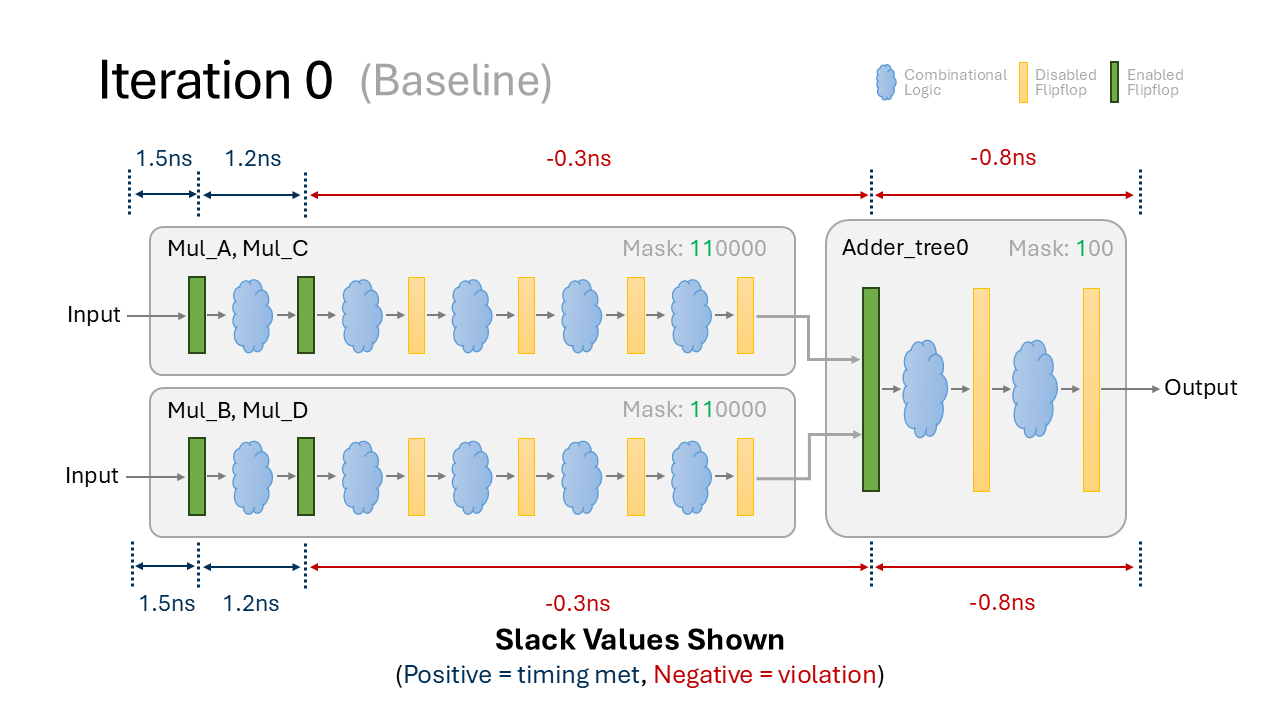

Timing Violated For nom_ss_100C_1v60
ALL REGISTER PATHS
From adder_tree0 Pipeline stage 0 to OUTPUT Pipeline stage None : -0.803339
From mul_A Pipeline stage 1 to adder_tree0 Pipeline stage 0 : -0.318683
From mul_B Pipeline stage 1 to adder_tree0 Pipeline stage 0 : -0.318683
From mul_C Pipeline stage 1 to adder_tree0 Pipeline stage 0 : -0.318683
From mul_D Pipeline stage 1 to adder_tree0 Pipeline stage 0 : -0.318683
From mul_A Pipeline stage 0 to mul_A Pipeline stage 1 : 1.241792
From mul_B Pipeline stage 0 to mul_B Pipeline stage 1 : 1.241792
From mul_C Pipeline stage 0 to mul_C Pipeline stage 1 : 1.241792
From mul_D Pipeline stage 0 to mul_D Pipeline stage 1 : 1.241792
From INPUT Pipeline stage None to mul_A Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_B Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_C Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_D Pipeline stage 0 : 1.533208
adder_tree0 Pipeline Mask Changed from 100 to 01

──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

──────────────────────────────────────── Static Timing Analysis (Pre-PnR) ─────────────────────────────────────────

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┓
┃                      ┃       ┃       ┃      ┃       ┃ of   ┃       ┃      ┃       ┃      ┃ of    ┃      ┃       ┃
┃                      ┃       ┃ Reg   ┃      ┃       ┃ whi… ┃       ┃ Reg  ┃       ┃      ┃ which ┃      ┃       ┃
┃                      ┃ Hold  ┃ to    ┃      ┃ Hold  ┃ reg  ┃ Setup ┃ to   ┃       ┃ Set… ┃ reg   ┃ Max  ┃ Max   ┃
┃                      ┃ Worst ┃ Reg   ┃ Hold ┃ Vio   ┃ to   ┃ Worst ┃ Reg  ┃ Setup ┃ Vio  ┃ to    ┃ Cap  ┃ Slew  ┃
┃ Corner/Group         ┃ Slack ┃ Paths ┃ TNS  ┃ Count ┃ reg  ┃ Slack ┃ Pat… ┃ TNS   ┃ Cou… ┃ reg   ┃ Vio… ┃ Viol… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━┩
│ Overall              │ 0.39… │ 0.39… │ 0.0… │ 0     │ 0    │ -2.3… │ -2.… │ -14.… │ 10   │ 10    │ 1    │ 0     │
│ nom_tt_025C_1v80     │ 0.61… │ 0.61… │ 0.0… │ 0     │ 0    │ 1.66… │ 1.6… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
│ nom_ss_100C_1v60     │ 1.24… │ 1.24… │ 0.0… │ 0     │ 0    │ -2.3… │ -2.… │ -14.… │ 10   │ 10    │ 0    │ 0     │
│ nom_ff_n40C_1v95     │ 0.39… │ 0.39… │ 0.0… │ 0     │ 0    │ 3.09… │ 3.0… │ 0.00… │ 0    │ 0     │ 1    │ 0     │
└──────────────────────┴───────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┘

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃                      ┃ Hold     ┃ Reg to   ┃          ┃          ┃ of which  ┃ Setup    ┃           ┃          ┃           ┃ of which ┃           ┃          ┃
┃                      ┃ Worst    ┃ Reg      ┃          ┃ Hold Vio ┃ reg to    ┃ Worst    ┃ Reg to    ┃ Setup    ┃ Setup Vio ┃ reg to   ┃ Max Cap   ┃ Max Slew ┃
┃ Corner/Group         ┃ Slack    ┃ Paths    ┃ Hold TNS ┃ Count    ┃ reg       ┃ Slack    ┃ Reg Paths ┃ TNS      ┃ Count     ┃ reg      ┃ Violatio… ┃ Violati… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Overall              │ 0.3949   │ 0.3949   │ 0.0000   │ 0        │ 0         │ -2.3661  │ -2.3661   │ -14.7424 │ 10        │ 10       │ 1         │ 0        │
│ nom_tt_025C_1v80     │ 0.6192   │ 0.6192   │ 0.0000   │ 0        │ 0         │ 1.6673   │ 1.6673    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
│ nom_ss_100C_1v60     │ 1.2418   │ 1.2418   │ 0.0000   │ 0        │ 0         │ -2.3661  │ -2.3661   │ -14.7424 │ 10        │ 10       │ 0         │ 0        │
│ nom_ff_n40C_1v95     │ 0.3949   │ 0.3949   │ 0.0000   │ 0        │ 0         │ 3.0949   │ 3.0949    │ 0.0000   │ 0         │ 0        │ 1         │ 0        │
└──────────────────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┘

Iteration 1
Current Pipeline Configuration


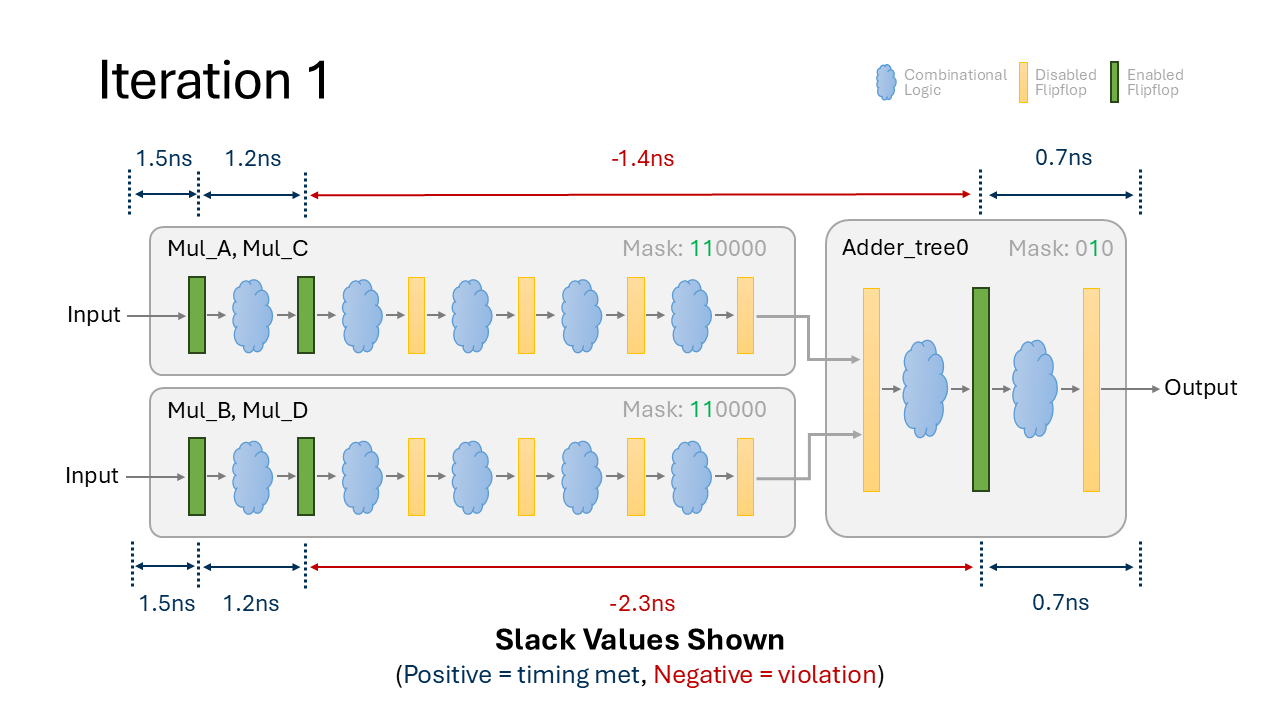

Timing Violated For nom_ss_100C_1v60
ALL REGISTER PATHS
From mul_B Pipeline stage 1 to adder_tree0 Pipeline stage 1 : -2.366118
From mul_D Pipeline stage 1 to adder_tree0 Pipeline stage 1 : -2.366118
From mul_A Pipeline stage 1 to adder_tree0 Pipeline stage 1 : -1.424273
From mul_C Pipeline stage 1 to adder_tree0 Pipeline stage 1 : -1.424273
From adder_tree0 Pipeline stage 1 to OUTPUT Pipeline stage None : 0.719662
From mul_A Pipeline stage 0 to mul_A Pipeline stage 1 : 1.241792
From mul_B Pipeline stage 0 to mul_B Pipeline stage 1 : 1.241792
From mul_C Pipeline stage 0 to mul_C Pipeline stage 1 : 1.241792
From mul_D Pipeline stage 0 to mul_D Pipeline stage 1 : 1.241792
From INPUT Pipeline stage None to mul_A Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_B Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_C Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_D Pipeline stage 0 : 1.533208
mul_B Pipeline Mask Changed from 110000 to 101000

──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

──────────────────────────────────────── Static Timing Analysis (Pre-PnR) ─────────────────────────────────────────

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┓
┃                      ┃       ┃       ┃      ┃       ┃ of   ┃       ┃      ┃       ┃      ┃ of    ┃      ┃       ┃
┃                      ┃       ┃ Reg   ┃      ┃       ┃ whi… ┃       ┃ Reg  ┃       ┃      ┃ which ┃      ┃       ┃
┃                      ┃ Hold  ┃ to    ┃      ┃ Hold  ┃ reg  ┃ Setup ┃ to   ┃       ┃ Set… ┃ reg   ┃ Max  ┃ Max   ┃
┃                      ┃ Worst ┃ Reg   ┃ Hold ┃ Vio   ┃ to   ┃ Worst ┃ Reg  ┃ Setup ┃ Vio  ┃ to    ┃ Cap  ┃ Slew  ┃
┃ Corner/Group         ┃ Slack ┃ Paths ┃ TNS  ┃ Count ┃ reg  ┃ Slack ┃ Pat… ┃ TNS   ┃ Cou… ┃ reg   ┃ Vio… ┃ Viol… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━┩
│ Overall              │ 0.45… │ 0.45… │ 0.0… │ 0     │ 0    │ -1.5… │ -1.… │ -7.3… │ 6    │ 6     │ 1    │ 0     │
│ nom_tt_025C_1v80     │ 0.70… │ 0.70… │ 0.0… │ 0     │ 0    │ 2.04… │ 2.0… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
│ nom_ss_100C_1v60     │ 1.40… │ 1.40… │ 0.0… │ 0     │ 0    │ -1.5… │ -1.… │ -7.3… │ 6    │ 6     │ 0    │ 0     │
│ nom_ff_n40C_1v95     │ 0.45… │ 0.45… │ 0.0… │ 0     │ 0    │ 3.33… │ 3.3… │ 0.00… │ 0    │ 0     │ 1    │ 0     │
└──────────────────────┴───────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┘

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃                      ┃ Hold     ┃ Reg to   ┃          ┃          ┃ of which  ┃ Setup    ┃           ┃          ┃           ┃ of which ┃           ┃          ┃
┃                      ┃ Worst    ┃ Reg      ┃          ┃ Hold Vio ┃ reg to    ┃ Worst    ┃ Reg to    ┃ Setup    ┃ Setup Vio ┃ reg to   ┃ Max Cap   ┃ Max Slew ┃
┃ Corner/Group         ┃ Slack    ┃ Paths    ┃ Hold TNS ┃ Count    ┃ reg       ┃ Slack    ┃ Reg Paths ┃ TNS      ┃ Count     ┃ reg      ┃ Violatio… ┃ Violati… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Overall              │ 0.4503   │ 0.4503   │ 0.0000   │ 0        │ 0         │ -1.5794  │ -1.5794   │ -7.3802  │ 6         │ 6        │ 1         │ 0        │
│ nom_tt_025C_1v80     │ 0.7068   │ 0.7068   │ 0.0000   │ 0        │ 0         │ 2.0463   │ 2.0463    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
│ nom_ss_100C_1v60     │ 1.4052   │ 1.4052   │ 0.0000   │ 0        │ 0         │ -1.5794  │ -1.5794   │ -7.3802  │ 6         │ 6        │ 0         │ 0        │
│ nom_ff_n40C_1v95     │ 0.4503   │ 0.4503   │ 0.0000   │ 0        │ 0         │ 3.3359   │ 3.3359    │ 0.0000   │ 0         │ 0        │ 1         │ 0        │
└──────────────────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┘

Iteration 2
Current Pipeline Configuration


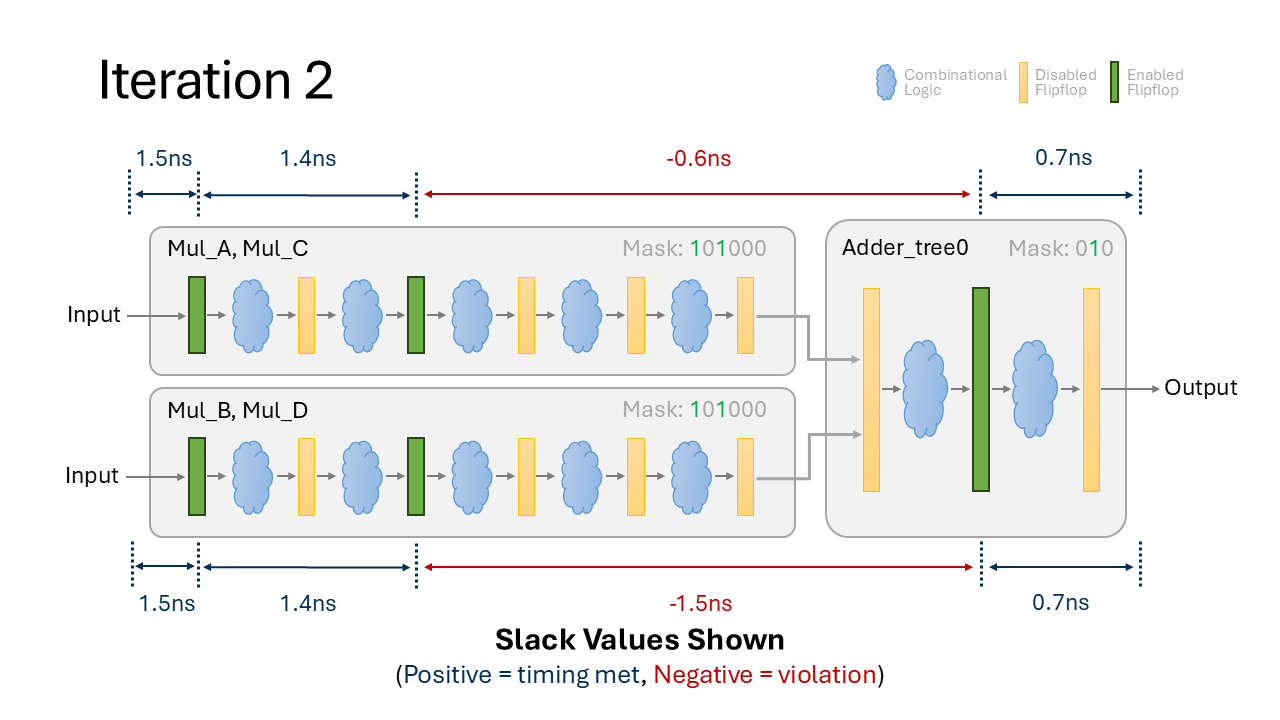

Timing Violated For nom_ss_100C_1v60
ALL REGISTER PATHS
From mul_B Pipeline stage 2 to adder_tree0 Pipeline stage 1 : -1.57943
From mul_D Pipeline stage 2 to adder_tree0 Pipeline stage 1 : -1.57943
From mul_A Pipeline stage 2 to adder_tree0 Pipeline stage 1 : -0.637584
From mul_C Pipeline stage 2 to adder_tree0 Pipeline stage 1 : -0.637584
From adder_tree0 Pipeline stage 1 to OUTPUT Pipeline stage None : 0.719662
From mul_A Pipeline stage 0 to mul_A Pipeline stage 2 : 1.4052
From mul_B Pipeline stage 0 to mul_B Pipeline stage 2 : 1.4052
From mul_C Pipeline stage 0 to mul_C Pipeline stage 2 : 1.4052
From mul_D Pipeline stage 0 to mul_D Pipeline stage 2 : 1.4052
From INPUT Pipeline stage None to mul_A Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_B Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_C Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_D Pipeline stage 0 : 1.533208
mul_B Pipeline Mask Changed from 101000 to 100100
mul_D Pip

──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

──────────────────────────────────────── Static Timing Analysis (Pre-PnR) ─────────────────────────────────────────

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┓
┃                      ┃       ┃       ┃      ┃       ┃ of   ┃       ┃      ┃       ┃      ┃ of    ┃      ┃       ┃
┃                      ┃       ┃ Reg   ┃      ┃       ┃ whi… ┃       ┃ Reg  ┃       ┃      ┃ which ┃      ┃       ┃
┃                      ┃ Hold  ┃ to    ┃      ┃ Hold  ┃ reg  ┃ Setup ┃ to   ┃       ┃ Set… ┃ reg   ┃ Max  ┃ Max   ┃
┃                      ┃ Worst ┃ Reg   ┃ Hold ┃ Vio   ┃ to   ┃ Worst ┃ Reg  ┃ Setup ┃ Vio  ┃ to    ┃ Cap  ┃ Slew  ┃
┃ Corner/Group         ┃ Slack ┃ Paths ┃ TNS  ┃ Count ┃ reg  ┃ Slack ┃ Pat… ┃ TNS   ┃ Cou… ┃ reg   ┃ Vio… ┃ Viol… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━┩
│ Overall              │ 0.50… │ 0.50… │ 0.0… │ 0     │ 0    │ -0.9… │ -0.… │ -3.6… │ 6    │ 6     │ 0    │ 0     │
│ nom_tt_025C_1v80     │ 0.78… │ 0.78… │ 0.0… │ 0     │ 0    │ 2.37… │ 2.3… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
│ nom_ss_100C_1v60     │ 1.53… │ 1.55… │ 0.0… │ 0     │ 0    │ -0.9… │ -0.… │ -3.6… │ 6    │ 6     │ 0    │ 0     │
│ nom_ff_n40C_1v95     │ 0.50… │ 0.50… │ 0.0… │ 0     │ 0    │ 3.40… │ 3.5… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
└──────────────────────┴───────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┘

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃                      ┃ Hold     ┃ Reg to   ┃          ┃          ┃ of which  ┃ Setup    ┃           ┃          ┃           ┃ of which ┃           ┃          ┃
┃                      ┃ Worst    ┃ Reg      ┃          ┃ Hold Vio ┃ reg to    ┃ Worst    ┃ Reg to    ┃ Setup    ┃ Setup Vio ┃ reg to   ┃ Max Cap   ┃ Max Slew ┃
┃ Corner/Group         ┃ Slack    ┃ Paths    ┃ Hold TNS ┃ Count    ┃ reg       ┃ Slack    ┃ Reg Paths ┃ TNS      ┃ Count     ┃ reg      ┃ Violatio… ┃ Violati… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Overall              │ 0.5019   │ 0.5019   │ 0.0000   │ 0        │ 0         │ -0.9526  │ -0.9526   │ -3.6194  │ 6         │ 6        │ 0         │ 0        │
│ nom_tt_025C_1v80     │ 0.7851   │ 0.7851   │ 0.0000   │ 0        │ 0         │ 2.3744   │ 2.3744    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
│ nom_ss_100C_1v60     │ 1.5332   │ 1.5518   │ 0.0000   │ 0        │ 0         │ -0.9526  │ -0.9526   │ -3.6194  │ 6         │ 6        │ 0         │ 0        │
│ nom_ff_n40C_1v95     │ 0.5019   │ 0.5019   │ 0.0000   │ 0        │ 0         │ 3.4018   │ 3.5472    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
└──────────────────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┘

Iteration 3
Current Pipeline Configuration


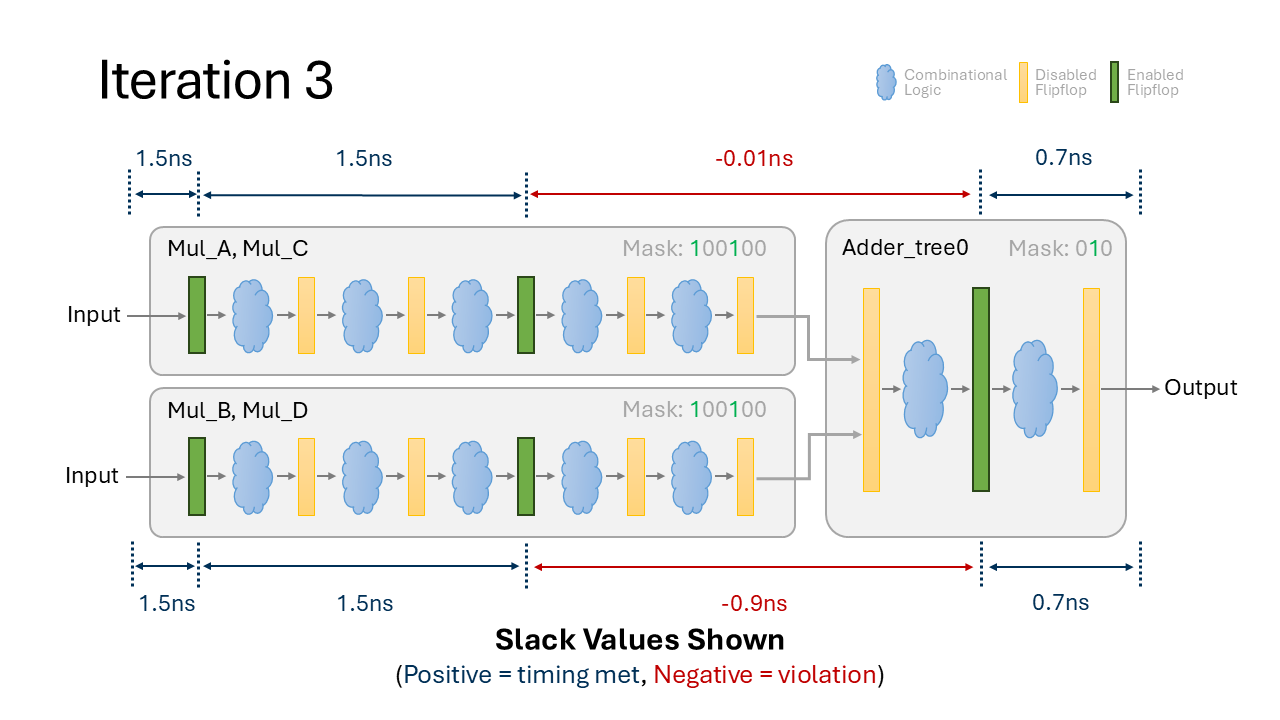

Timing Violated For nom_ss_100C_1v60
ALL REGISTER PATHS
From mul_B Pipeline stage 3 to adder_tree0 Pipeline stage 1 : -0.952642
From mul_D Pipeline stage 3 to adder_tree0 Pipeline stage 1 : -0.952642
From mul_A Pipeline stage 3 to adder_tree0 Pipeline stage 1 : -0.010796
From mul_C Pipeline stage 3 to adder_tree0 Pipeline stage 1 : -0.010796
From adder_tree0 Pipeline stage 1 to OUTPUT Pipeline stage None : 0.719662
From INPUT Pipeline stage None to mul_A Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_B Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_C Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_D Pipeline stage 0 : 1.533208
From mul_A Pipeline stage 0 to mul_A Pipeline stage 3 : 1.551815
From mul_B Pipeline stage 0 to mul_B Pipeline stage 3 : 1.551815
From mul_C Pipeline stage 0 to mul_C Pipeline stage 3 : 1.551815
From mul_D Pipeline stage 0 to mul_D Pipeline stage 3 : 1.551815
mul_B Pipeline Mask Changed from 100100 to 100010

──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

──────────────────────────────────────── Static Timing Analysis (Pre-PnR) ─────────────────────────────────────────

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┓
┃                      ┃       ┃       ┃      ┃       ┃ of   ┃       ┃      ┃       ┃      ┃ of    ┃      ┃       ┃
┃                      ┃       ┃ Reg   ┃      ┃       ┃ whi… ┃       ┃ Reg  ┃       ┃      ┃ which ┃      ┃       ┃
┃                      ┃ Hold  ┃ to    ┃      ┃ Hold  ┃ reg  ┃ Setup ┃ to   ┃       ┃ Set… ┃ reg   ┃ Max  ┃ Max   ┃
┃                      ┃ Worst ┃ Reg   ┃ Hold ┃ Vio   ┃ to   ┃ Worst ┃ Reg  ┃ Setup ┃ Vio  ┃ to    ┃ Cap  ┃ Slew  ┃
┃ Corner/Group         ┃ Slack ┃ Paths ┃ TNS  ┃ Count ┃ reg  ┃ Slack ┃ Pat… ┃ TNS   ┃ Cou… ┃ reg   ┃ Vio… ┃ Viol… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━┩
│ Overall              │ 0.48… │ 0.48… │ 0.0… │ 0     │ 0    │ -0.0… │ -0.… │ -0.0… │ 2    │ 2     │ 0    │ 0     │
│ nom_tt_025C_1v80     │ 0.77… │ 0.77… │ 0.0… │ 0     │ 0    │ 2.68… │ 2.8… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
│ nom_ss_100C_1v60     │ 1.53… │ 1.56… │ 0.0… │ 0     │ 0    │ -0.0… │ -0.… │ -0.0… │ 2    │ 2     │ 0    │ 0     │
│ nom_ff_n40C_1v95     │ 0.48… │ 0.48… │ 0.0… │ 0     │ 0    │ 3.40… │ 3.8… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
└──────────────────────┴───────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┘

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃                      ┃ Hold     ┃ Reg to   ┃          ┃          ┃ of which  ┃ Setup    ┃           ┃          ┃           ┃ of which ┃           ┃          ┃
┃                      ┃ Worst    ┃ Reg      ┃          ┃ Hold Vio ┃ reg to    ┃ Worst    ┃ Reg to    ┃ Setup    ┃ Setup Vio ┃ reg to   ┃ Max Cap   ┃ Max Slew ┃
┃ Corner/Group         ┃ Slack    ┃ Paths    ┃ Hold TNS ┃ Count    ┃ reg       ┃ Slack    ┃ Reg Paths ┃ TNS      ┃ Count     ┃ reg      ┃ Violatio… ┃ Violati… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Overall              │ 0.4867   │ 0.4867   │ 0.0000   │ 0        │ 0         │ -0.0243  │ -0.0243   │ -0.0486  │ 2         │ 2        │ 0         │ 0        │
│ nom_tt_025C_1v80     │ 0.7757   │ 0.7757   │ 0.0000   │ 0        │ 0         │ 2.6872   │ 2.8356    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
│ nom_ss_100C_1v60     │ 1.5332   │ 1.5619   │ 0.0000   │ 0        │ 0         │ -0.0243  │ -0.0243   │ -0.0486  │ 2         │ 2        │ 0         │ 0        │
│ nom_ff_n40C_1v95     │ 0.4867   │ 0.4867   │ 0.0000   │ 0        │ 0         │ 3.4018   │ 3.8383    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
└──────────────────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┘

Iteration 4
Current Pipeline Configuration


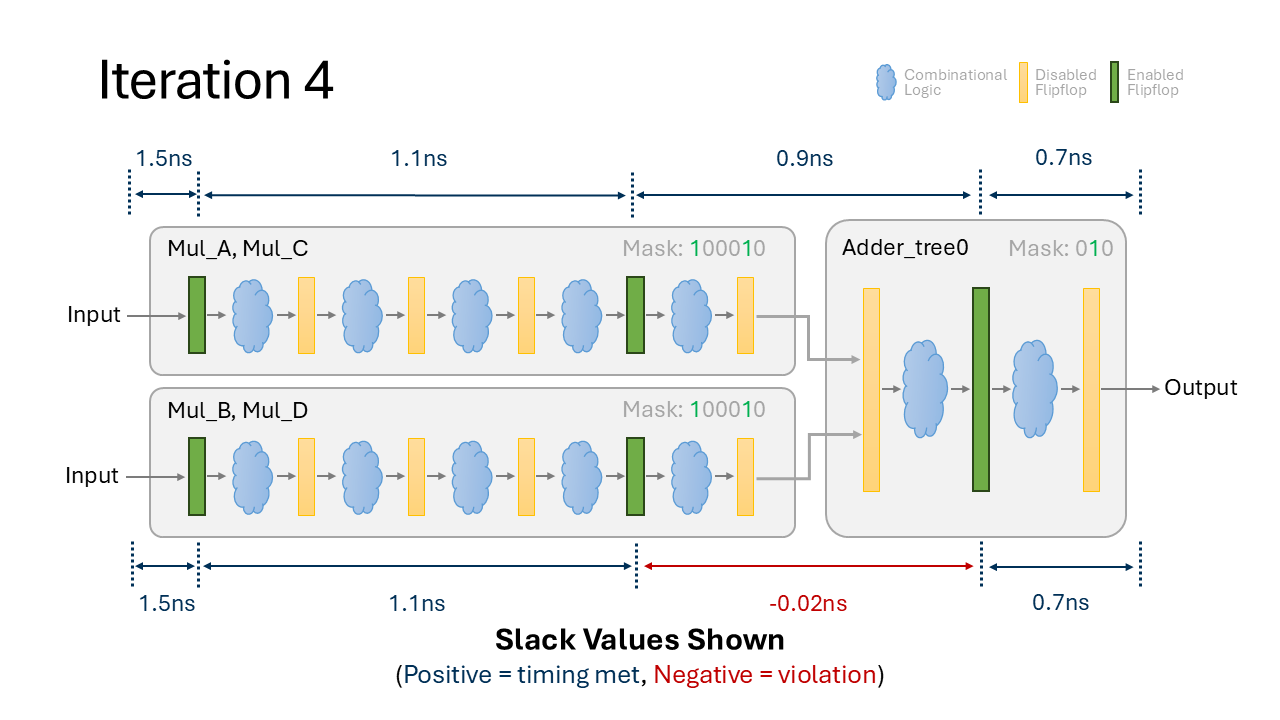

Timing Violated For nom_ss_100C_1v60
ALL REGISTER PATHS
From mul_B Pipeline stage 4 to adder_tree0 Pipeline stage 1 : -0.024292
From mul_D Pipeline stage 4 to adder_tree0 Pipeline stage 1 : -0.024292
From adder_tree0 Pipeline stage 1 to OUTPUT Pipeline stage None : 0.719662
From mul_A Pipeline stage 4 to adder_tree0 Pipeline stage 1 : 0.917553
From mul_C Pipeline stage 4 to adder_tree0 Pipeline stage 1 : 0.917553
From mul_A Pipeline stage 0 to mul_A Pipeline stage 4 : 1.147286
From mul_B Pipeline stage 0 to mul_B Pipeline stage 4 : 1.147286
From mul_C Pipeline stage 0 to mul_C Pipeline stage 4 : 1.147286
From mul_D Pipeline stage 0 to mul_D Pipeline stage 4 : 1.147286
From INPUT Pipeline stage None to mul_A Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_B Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_C Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_D Pipeline stage 0 : 1.533208
mul_B Pipeline Mask Changed from 100010 to 100001
m

──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

──────────────────────────────────────── Static Timing Analysis (Pre-PnR) ─────────────────────────────────────────

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┓
┃                      ┃       ┃       ┃      ┃       ┃ of   ┃       ┃      ┃       ┃      ┃ of    ┃      ┃       ┃
┃                      ┃       ┃ Reg   ┃      ┃       ┃ whi… ┃       ┃ Reg  ┃       ┃      ┃ which ┃      ┃       ┃
┃                      ┃ Hold  ┃ to    ┃      ┃ Hold  ┃ reg  ┃ Setup ┃ to   ┃       ┃ Set… ┃ reg   ┃ Max  ┃ Max   ┃
┃                      ┃ Worst ┃ Reg   ┃ Hold ┃ Vio   ┃ to   ┃ Worst ┃ Reg  ┃ Setup ┃ Vio  ┃ to    ┃ Cap  ┃ Slew  ┃
┃ Corner/Group         ┃ Slack ┃ Paths ┃ TNS  ┃ Count ┃ reg  ┃ Slack ┃ Pat… ┃ TNS   ┃ Cou… ┃ reg   ┃ Vio… ┃ Viol… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━┩
│ Overall              │ 0.44… │ 0.44… │ 0.0… │ 0     │ 0    │ -0.9… │ -0.… │ -4.0… │ 6    │ 6     │ 0    │ 0     │
│ nom_tt_025C_1v80     │ 0.70… │ 0.70… │ 0.0… │ 0     │ 0    │ 2.32… │ 2.3… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
│ nom_ss_100C_1v60     │ 1.43… │ 1.43… │ 0.0… │ 0     │ 0    │ -0.9… │ -0.… │ -4.0… │ 6    │ 6     │ 0    │ 0     │
│ nom_ff_n40C_1v95     │ 0.44… │ 0.44… │ 0.0… │ 0     │ 0    │ 3.40… │ 3.4… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
└──────────────────────┴───────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┘

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃                      ┃ Hold     ┃ Reg to   ┃          ┃          ┃ of which  ┃ Setup    ┃           ┃          ┃           ┃ of which ┃           ┃          ┃
┃                      ┃ Worst    ┃ Reg      ┃          ┃ Hold Vio ┃ reg to    ┃ Worst    ┃ Reg to    ┃ Setup    ┃ Setup Vio ┃ reg to   ┃ Max Cap   ┃ Max Slew ┃
┃ Corner/Group         ┃ Slack    ┃ Paths    ┃ Hold TNS ┃ Count    ┃ reg       ┃ Slack    ┃ Reg Paths ┃ TNS      ┃ Count     ┃ reg      ┃ Violatio… ┃ Violati… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Overall              │ 0.4402   │ 0.4402   │ 0.0000   │ 0        │ 0         │ -0.9343  │ -0.9343   │ -4.0697  │ 6         │ 6        │ 0         │ 0        │
│ nom_tt_025C_1v80     │ 0.7047   │ 0.7047   │ 0.0000   │ 0        │ 0         │ 2.3249   │ 2.3249    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
│ nom_ss_100C_1v60     │ 1.4306   │ 1.4306   │ 0.0000   │ 0        │ 0         │ -0.9343  │ -0.9343   │ -4.0697  │ 6         │ 6        │ 0         │ 0        │
│ nom_ff_n40C_1v95     │ 0.4402   │ 0.4402   │ 0.0000   │ 0        │ 0         │ 3.4018   │ 3.4766    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
└──────────────────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┘

Iteration 5
Current Pipeline Configuration


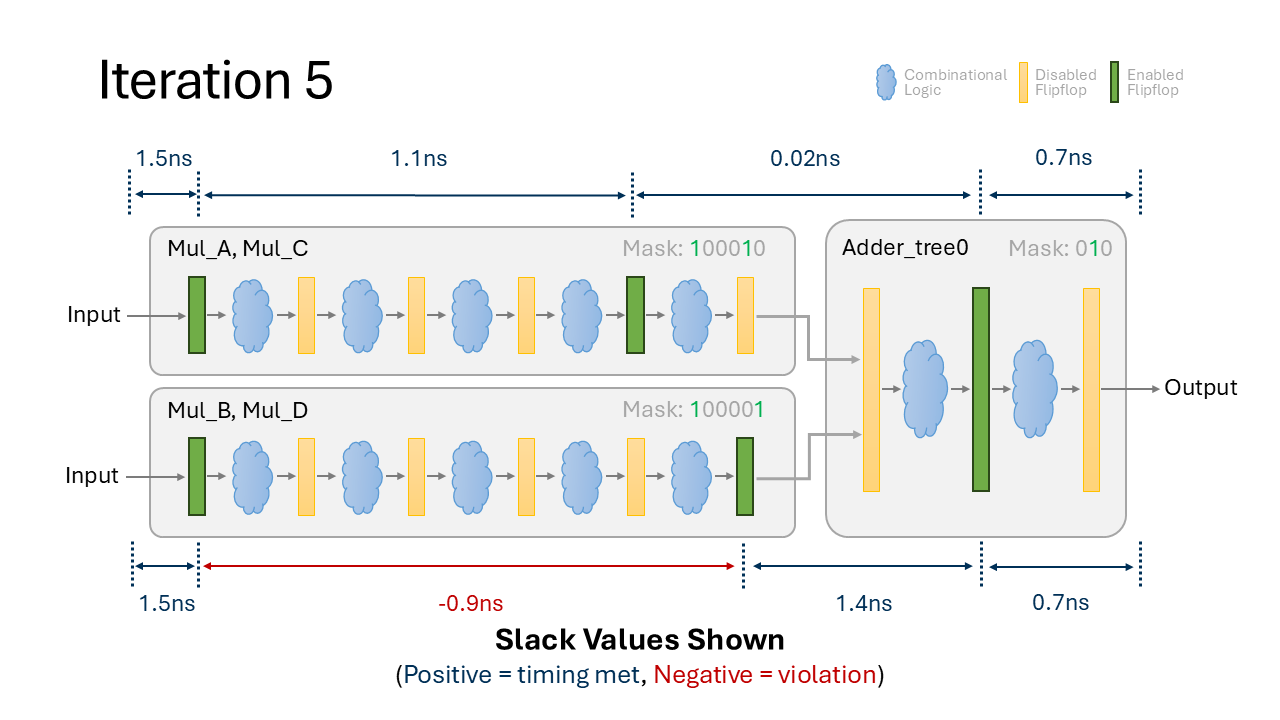

Timing Violated For nom_ss_100C_1v60
ALL REGISTER PATHS
From mul_B Pipeline stage 0 to mul_B Pipeline stage 5 : -0.934317
From mul_D Pipeline stage 0 to mul_D Pipeline stage 5 : -0.934317
From mul_A Pipeline stage 4 to adder_tree0 Pipeline stage 1 : 0.020152
From mul_C Pipeline stage 4 to adder_tree0 Pipeline stage 1 : 0.020152
From adder_tree0 Pipeline stage 1 to OUTPUT Pipeline stage None : 0.719662
From mul_A Pipeline stage 0 to mul_A Pipeline stage 4 : 1.147286
From mul_C Pipeline stage 0 to mul_C Pipeline stage 4 : 1.147286
From mul_D Pipeline stage 5 to adder_tree0 Pipeline stage 1 : 1.43065
From mul_B Pipeline stage 5 to adder_tree0 Pipeline stage 1 : 1.45207
From INPUT Pipeline stage None to mul_A Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_B Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_C Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_D Pipeline stage 0 : 1.533208
mul_B Pipeline Mask Changed from 100001 to 010001
mul

──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

──────────────────────────────────────── Static Timing Analysis (Pre-PnR) ─────────────────────────────────────────

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┓
┃                      ┃       ┃       ┃      ┃       ┃ of   ┃       ┃      ┃       ┃      ┃ of    ┃      ┃       ┃
┃                      ┃       ┃ Reg   ┃      ┃       ┃ whi… ┃       ┃ Reg  ┃       ┃      ┃ which ┃      ┃       ┃
┃                      ┃ Hold  ┃ to    ┃      ┃ Hold  ┃ reg  ┃ Setup ┃ to   ┃       ┃ Set… ┃ reg   ┃ Max  ┃ Max   ┃
┃                      ┃ Worst ┃ Reg   ┃ Hold ┃ Vio   ┃ to   ┃ Worst ┃ Reg  ┃ Setup ┃ Vio  ┃ to    ┃ Cap  ┃ Slew  ┃
┃ Corner/Group         ┃ Slack ┃ Paths ┃ TNS  ┃ Count ┃ reg  ┃ Slack ┃ Pat… ┃ TNS   ┃ Cou… ┃ reg   ┃ Vio… ┃ Viol… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━┩
│ Overall              │ 0.44… │ 0.44… │ 0.0… │ 0     │ 0    │ -0.1… │ -0.… │ -0.2… │ 2    │ 2     │ 0    │ 0     │
│ nom_tt_025C_1v80     │ 0.70… │ 0.70… │ 0.0… │ 0     │ 0    │ 2.72… │ 2.7… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
│ nom_ss_100C_1v60     │ 1.43… │ 1.43… │ 0.0… │ 0     │ 0    │ -0.1… │ -0.… │ -0.2… │ 2    │ 2     │ 0    │ 0     │
│ nom_ff_n40C_1v95     │ 0.44… │ 0.44… │ 0.0… │ 0     │ 0    │ 3.50… │ 3.7… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
└──────────────────────┴───────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┘

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃                      ┃ Hold     ┃ Reg to   ┃          ┃          ┃ of which  ┃ Setup    ┃           ┃          ┃           ┃ of which ┃           ┃          ┃
┃                      ┃ Worst    ┃ Reg      ┃          ┃ Hold Vio ┃ reg to    ┃ Worst    ┃ Reg to    ┃ Setup    ┃ Setup Vio ┃ reg to   ┃ Max Cap   ┃ Max Slew ┃
┃ Corner/Group         ┃ Slack    ┃ Paths    ┃ Hold TNS ┃ Count    ┃ reg       ┃ Slack    ┃ Reg Paths ┃ TNS      ┃ Count     ┃ reg      ┃ Violatio… ┃ Violati… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Overall              │ 0.4402   │ 0.4402   │ 0.0000   │ 0        │ 0         │ -0.1170  │ -0.1170   │ -0.2340  │ 2         │ 2        │ 0         │ 0        │
│ nom_tt_025C_1v80     │ 0.7047   │ 0.7047   │ 0.0000   │ 0        │ 0         │ 2.7270   │ 2.7270    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
│ nom_ss_100C_1v60     │ 1.4306   │ 1.4306   │ 0.0000   │ 0        │ 0         │ -0.1170  │ -0.1170   │ -0.2340  │ 2         │ 2        │ 0         │ 0        │
│ nom_ff_n40C_1v95     │ 0.4402   │ 0.4402   │ 0.0000   │ 0        │ 0         │ 3.5002   │ 3.7370    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
└──────────────────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┘

Iteration 6
Current Pipeline Configuration


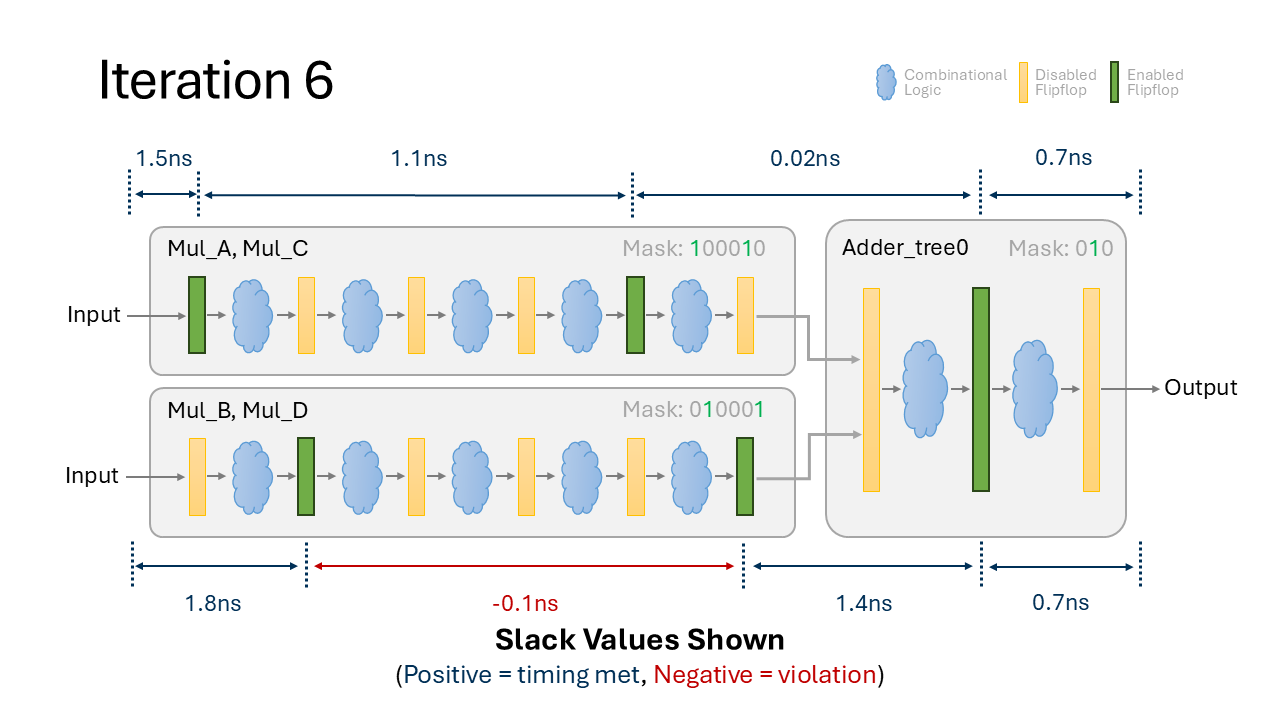

Timing Violated For nom_ss_100C_1v60
ALL REGISTER PATHS
From mul_B Pipeline stage 1 to mul_B Pipeline stage 5 : -0.117015
From mul_D Pipeline stage 1 to mul_D Pipeline stage 5 : -0.117015
From mul_A Pipeline stage 4 to adder_tree0 Pipeline stage 1 : 0.020152
From mul_C Pipeline stage 4 to adder_tree0 Pipeline stage 1 : 0.020152
From mul_A Pipeline stage 0 to mul_A Pipeline stage 4 : 1.147286
From mul_C Pipeline stage 0 to mul_C Pipeline stage 4 : 1.147286
From mul_D Pipeline stage 5 to adder_tree0 Pipeline stage 1 : 1.43065
From adder_tree0 Pipeline stage 1 to OUTPUT Pipeline stage None : 1.449503
From mul_B Pipeline stage 5 to adder_tree0 Pipeline stage 1 : 1.45207
From INPUT Pipeline stage None to mul_A Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_C Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_B Pipeline stage 1 : 1.866623
From INPUT Pipeline stage None to mul_D Pipeline stage 1 : 1.866623
mul_B Pipeline Mask Changed from 010001 to 001001
mul

──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

──────────────────────────────────────── Static Timing Analysis (Pre-PnR) ─────────────────────────────────────────

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┓
┃                      ┃       ┃       ┃      ┃       ┃ of   ┃       ┃      ┃       ┃      ┃ of    ┃      ┃       ┃
┃                      ┃       ┃ Reg   ┃      ┃       ┃ whi… ┃       ┃ Reg  ┃       ┃      ┃ which ┃      ┃       ┃
┃                      ┃ Hold  ┃ to    ┃      ┃ Hold  ┃ reg  ┃ Setup ┃ to   ┃       ┃ Set… ┃ reg   ┃ Max  ┃ Max   ┃
┃                      ┃ Worst ┃ Reg   ┃ Hold ┃ Vio   ┃ to   ┃ Worst ┃ Reg  ┃ Setup ┃ Vio  ┃ to    ┃ Cap  ┃ Slew  ┃
┃ Corner/Group         ┃ Slack ┃ Paths ┃ TNS  ┃ Count ┃ reg  ┃ Slack ┃ Pat… ┃ TNS   ┃ Cou… ┃ reg   ┃ Vio… ┃ Viol… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━┩
│ Overall              │ 0.41… │ 0.41… │ 0.0… │ 0     │ 0    │ 0.02… │ 0.0… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
│ nom_tt_025C_1v80     │ 0.66… │ 0.66… │ 0.0… │ 0     │ 0    │ 2.68… │ 2.8… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
│ nom_ss_100C_1v60     │ 1.33… │ 1.33… │ 0.0… │ 0     │ 0    │ 0.02… │ 0.0… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
│ nom_ff_n40C_1v95     │ 0.41… │ 0.41… │ 0.0… │ 0     │ 0    │ 3.40… │ 3.8… │ 0.00… │ 0    │ 0     │ 0    │ 0     │
└──────────────────────┴───────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┘

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃                      ┃ Hold     ┃ Reg to   ┃          ┃          ┃ of which  ┃ Setup    ┃           ┃          ┃           ┃ of which ┃           ┃          ┃
┃                      ┃ Worst    ┃ Reg      ┃          ┃ Hold Vio ┃ reg to    ┃ Worst    ┃ Reg to    ┃ Setup    ┃ Setup Vio ┃ reg to   ┃ Max Cap   ┃ Max Slew ┃
┃ Corner/Group         ┃ Slack    ┃ Paths    ┃ Hold TNS ┃ Count    ┃ reg       ┃ Slack    ┃ Reg Paths ┃ TNS      ┃ Count     ┃ reg      ┃ Violatio… ┃ Violati… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Overall              │ 0.4127   │ 0.4127   │ 0.0000   │ 0        │ 0         │ 0.0202   │ 0.0202    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
│ nom_tt_025C_1v80     │ 0.6604   │ 0.6604   │ 0.0000   │ 0        │ 0         │ 2.6872   │ 2.8554    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
│ nom_ss_100C_1v60     │ 1.3389   │ 1.3389   │ 0.0000   │ 0        │ 0         │ 0.0202   │ 0.0202    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
│ nom_ff_n40C_1v95     │ 0.4127   │ 0.4127   │ 0.0000   │ 0        │ 0         │ 3.4018   │ 3.8509    │ 0.0000   │ 0         │ 0        │ 0         │ 0        │
└──────────────────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┘

Iteration 7
Current Pipeline Configuration


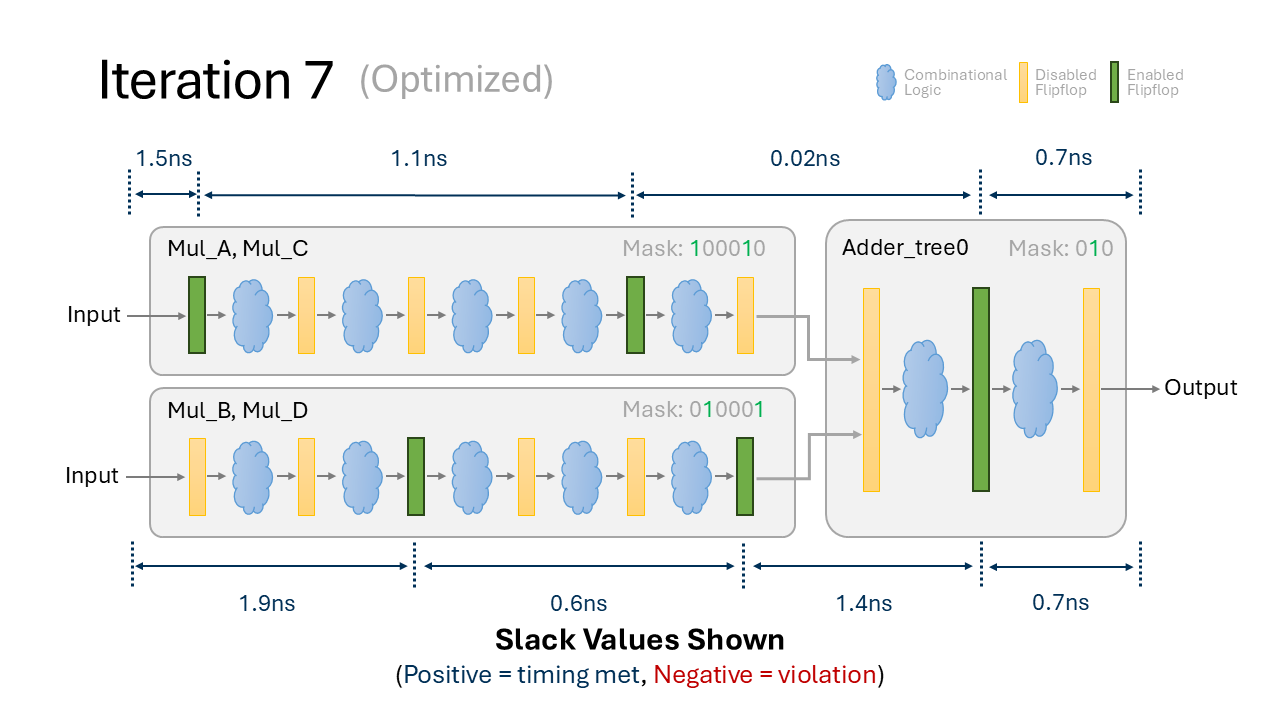

Timing Passed For nom_ss_100C_1v60 for clock period of 5.5
ALL REGISTER PATHS
From mul_A Pipeline stage 4 to adder_tree0 Pipeline stage 1 : 0.020152
From mul_C Pipeline stage 4 to adder_tree0 Pipeline stage 1 : 0.020152
From mul_B Pipeline stage 2 to mul_B Pipeline stage 5 : 0.669674
From mul_D Pipeline stage 2 to mul_D Pipeline stage 5 : 0.669674
From adder_tree0 Pipeline stage 1 to OUTPUT Pipeline stage None : 0.719662
From mul_A Pipeline stage 0 to mul_A Pipeline stage 4 : 1.147286
From mul_C Pipeline stage 0 to mul_C Pipeline stage 4 : 1.147286
From mul_D Pipeline stage 5 to adder_tree0 Pipeline stage 1 : 1.43065
From mul_B Pipeline stage 5 to adder_tree0 Pipeline stage 1 : 1.45207
From INPUT Pipeline stage None to mul_A Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_C Pipeline stage 0 : 1.533208
From INPUT Pipeline stage None to mul_B Pipeline stage 2 : 1.987894
From INPUT Pipeline stage None to mul_D Pipeline stage 2 : 1.987894


In [6]:
#@title Run the Retiming Algorithm
#@markdown Click the ▷ button to run the Retiming algorithm one iteration at a time. Press enter after each iteration to continue

# code for displaying multiple images in one figure

#import libraries
%cd /content/Retiming/Scripts

import openlane
import glob
from openlane.config import Config
from openlane.steps import Step
from openlane.state import State
import openlane.logging
from IPython.display import Image, display

import os
import json
import re
import copy
import shutil
import subprocess
import random

from metrics import InstanceDetails, TimingRptParser, StateOutMetrics

openlane.logging.set_log_level("CRITICAL")

'''
CONFIGURATIONS
'''
### Make Changes here ###
cwd_path = os.getcwd()
## Design Modules

no_slack_assumption = False
top_module = ["top_mult_addertree"]
design_paths = [f"{cwd_path}/../Design/Multiplier/array_multiplier.sv",
                f"{cwd_path}/../Design/AdderTree/AdderTree.sv",
                f"{cwd_path}/../Design/Top_mult_addertree/top_mult_addertree.sv"]

## Library Modules
lib_modules = ["pipeline_stage"]
lib_paths = [f"{cwd_path}/../Design/lib/{lib_module}.sv" for lib_module in lib_modules]
## Clock pin name
clock_pin = "clk"
## Clock period
clock_period = 5.5  # Working Clock Period
## Number of iterations for the algorithm
N_iterations = 50

FILES = [path for path in design_paths + lib_paths if path]
## No changes bellow this line ###

with open('metrics/utils.py') as f:
    exec(f.read())

'''
SYNTHESIS
'''
flag_stop = False
telemetry = {"attempted_pipeline_combinations":set(), "kill_count":0, "kill":False, "iterations":0}
backup_files = create_backup_files(design_paths)
while not flag_stop:
    for iterations in range(N_iterations):
        # Dumping raw netlist to extract instance details
        verilog_str = " ".join(FILES)
        yosys_cmd = f'rm -rf ./openlane_run/*yosys* ./openlane_run/*openroad*; mkdir -p ./openlane_run; yosys -Q -qq -p "read_verilog -sv {verilog_str}; hierarchy -top {top_module[0]}; proc; write_json ./openlane_run/raw_netlist.json"'
        # Run Yosys comman
        subprocess.run(yosys_cmd, shell=True, check=True)

        Config.interactive(
            top_module[0],  # Assume first element of top_module list is the top module
            PDK="sky130A",
            PDK_ROOT=os.getenv("VOLARE_FOLDER"),  # create .env file with VOLARE_FOLDER=<path to skywater-pdk>
            CLOCK_PORT = clock_pin,
            CLOCK_NET = clock_pin,
            CLOCK_PERIOD = clock_period,
            PRIMARY_GDSII_STREAMOUT_TOOL="klayout",
        )

        Synthesis = Step.factory.get("Yosys.Synthesis")
        synthesis = Synthesis(
            VERILOG_FILES=FILES,
            SYNTH_NO_FLAT=True,
            SYNTH_STRATEGY="DELAY 1",
            SYNTH_ABC_BUFFERING=True,            # Enable cell buffering
            state_in=State(),
        )
        synthesis.start()

        # Static Timing Analysis Pre-PNR (STA Pre-PNR)
        STAPrePNR = Step.factory.get("OpenROAD.STAPrePNR")
        sta_pre_pnr = STAPrePNR(
            PNR_SDC_FILE="pre_pnr_base.sdc",
            VERILOG_FILES=FILES,
            state_in=synthesis.state_out,  # Use the output state from synthesis as input state for STA Pre-PNR
        )
        sta_pre_pnr.start()

        # Parse Timing Data.
        it = telemetry["iterations"]
        print("============================================================")
        print(f"Iteration {it}")
        print("============================================================")
        img_path = f"../schematics/Slide{it + 1}.PNG"  # Adjust path if needed
        print(f"Current Pipeline Configuration")
        if os.path.exists(img_path):
            display(Image(filename=img_path,width=600,height=400))
        else:
            print(f"Image not found: {img_path}")
        openroad_state_path = glob.glob("./openlane_run/*-openroad-*/state_out.json")[0]
        stateout = StateOutMetrics(openroad_state_path)
        if stateout.nom_ss_100C_1v60.metrics["timing__hold__ws"] < 0 or stateout.nom_ss_100C_1v60.metrics["timing__setup__ws"] < 0:
            print("Timing Violated For nom_ss_100C_1v60")
            temp_telemetry = the_algorithm("nom_ss_100C_1v60",  telemetry)
            if temp_telemetry["kill"]:
                print("Kill Condition Met")
                break
            telemetry = temp_telemetry
        else:
            print(f"Timing Passed For nom_ss_100C_1v60 for clock period of {clock_period}")
            temp_telemetry = the_algorithm("nom_ss_100C_1v60",  telemetry)
            flag_stop = True
            break
        input("Please Press Enter:")

    if not flag_stop:
        print("============================================================")
        print("Make the design choice of either increasing the number of pipeline stages or increasing the clock period.")
        print("============================================================")
        break



###Results Comparison
After 7 iterations the design meets timing at a clock period of 5.5ns. The intial unoptimized design started with -0.8ns of negative slack for a minimum period of 6.3ns. The retiming algorithm therefore achieves a 13% deduction in mimimum clock period improving FMax from 158MHz to 182MHz \(15% increase\)

## Larger Design L2 Norm

In [8]:
#@markdown Click the ▷ button to run the retiming algorithm on the L2 Norm Design
!python3 colab_script_L2.py --clock-period=16

────────────────────────────────── Synthesis ───────────────────────────────────
─────────────────────── Static Timing Analysis (Pre-PnR) ───────────────────────
┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━┳━━━━┳━━━━┳━━━━┳━━━━┳━━━┳━━━━┳━━━┳━━━━┳━━━┳━━━━┳━━━┓
┃                      ┃    ┃    ┃    ┃    ┃ of ┃   ┃    ┃   ┃    ┃ … ┃    ┃   ┃
┃                      ┃    ┃ R… ┃    ┃    ┃ w… ┃   ┃ R… ┃   ┃    ┃ … ┃    ┃   ┃
┃                      ┃ H… ┃ to ┃    ┃ H… ┃ r… ┃ … ┃ to ┃   ┃ S… ┃ … ┃ M… ┃ … ┃
┃                      ┃ W… ┃ R… ┃ H… ┃ V… ┃ to ┃ … ┃ R… ┃ … ┃ V… ┃ … ┃ C… ┃ … ┃
┃ Corner/Group         ┃ S… ┃ P… ┃ T… ┃ C… ┃ r… ┃ … ┃ P… ┃ … ┃ C… ┃ … ┃ V… ┃ … ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━╇━━━━╇━━━━╇━━━━╇━━━━╇━━━╇━━━━╇━━━╇━━━━╇━━━╇━━━━╇━━━┩
│ Overall              │ 0… │ 0… │ 0… │ 0  │ 0  │ … │ -… │ … │ 56 │ … │ 1  │ … │
│ nom_tt_025C_1v80     │ 0… │ 0… │ 0… │ 0  │ 0  │ … │ 5… │ … │ 0  │ 0 │ 1  │ 0 │
│ nom_ss_100C_1v60     │ 1… │ 1… │ 0… │ 0  │ 0  │ … │ -… │ … │ 56 │ … │ 1  │ … │
│ nom_ff_n40C_1v95     │ 0… 

###Results Comparison
After 7 iterations the design meets timing at a clock period of 16ns. The intial unoptimized design started with -4.74ns of negative slack for a minimum period of 20.74ns. The retiming algorithm therefore achieves a 23% deduction in mimimum clock period improving FMax from 48MHz to 62.5MHz \(30% increase\)

### RTL2GDS Flow for L2 normalization Design

──────────────────────────────────────────────────── Synthesis ────────────────────────────────────────────────────

──────────────────────────────────────────── Floorplan Initialization ─────────────────────────────────────────────

─────────────────────────────────────────────── Tap/Decap Insertion ───────────────────────────────────────────────

────────────────────────────────────────────────── I/O Placement ──────────────────────────────────────────────────

────────────────────────────────────── Power Distribution Network Generation ──────────────────────────────────────

──────────────────────────────────────────────── Global Placement ─────────────────────────────────────────────────

─────────────────────────────────────────────── Detailed Placement ────────────────────────────────────────────────

────────────────────────────────────────────── Clock Tree Synthesis ───────────────────────────────────────────────

───────────────────────────────────────────────── Global Routing ──────────────────────────────────────────────────

──────────────────────────────────────────────── Detailed Routing ─────────────────────────────────────────────────

───────────────────────────────────────────────── Fill Insertion ──────────────────────────────────────────────────

─────────────────────────────────── Parasitic Resistance/Capacitance Extraction ───────────────────────────────────

──────────────────────────────────────── Static Timing Analysis (Post-PnR) ────────────────────────────────────────

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┳━━━━━━┳━━━━━━━┓
┃                      ┃       ┃       ┃      ┃       ┃ of   ┃       ┃      ┃       ┃      ┃ of    ┃      ┃       ┃
┃                      ┃       ┃ Reg   ┃      ┃       ┃ whi… ┃       ┃ Reg  ┃       ┃      ┃ which ┃      ┃       ┃
┃                      ┃ Hold  ┃ to    ┃      ┃ Hold  ┃ reg  ┃ Setup ┃ to   ┃       ┃ Set… ┃ reg   ┃ Max  ┃ Max   ┃
┃                      ┃ Worst ┃ Reg   ┃ Hold ┃ Vio   ┃ to   ┃ Worst ┃ Reg  ┃ Setup ┃ Vio  ┃ to    ┃ Cap  ┃ Slew  ┃
┃ Corner/Group         ┃ Slack ┃ Paths ┃ TNS  ┃ Count ┃ reg  ┃ Slack ┃ Pat… ┃ TNS   ┃ Cou… ┃ reg   ┃ Vio… ┃ Viol… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━╇━━━━━━╇━━━━━━━┩
│ Overall              │ 0.02… │ 0.02… │ 0.0… │ 0     │ 0    │ -3.0… │ -3.… │ -99.… │ 131  │ 121   │ 15   │ 1610  │
│ nom_tt_025C_1v80     │ 0.18… │ 0.18… │ 0.0… │ 0     │ 0    │ 5.67… │ 6.1… │ 0.00… │ 0    │ 0     │ 6    │ 668   │
│ nom_ss_100C_1v60     │ 0.63… │ 0.63… │ 0.0… │ 0     │ 0    │ -2.6… │ -2.… │ -80.… │ 43   │ 40    │ 14   │ 1572  │
│ nom_ff_n40C_1v95     │ 0.03… │ 0.03… │ 0.0… │ 0     │ 0    │ 8.36… │ 9.8… │ 0.00… │ 0    │ 0     │ 6    │ 317   │
│ min_tt_025C_1v80     │ 0.18… │ 0.18… │ 0.0… │ 0     │ 0    │ 5.81… │ 6.4… │ 0.00… │ 0    │ 0     │ 6    │ 624   │
│ min_ss_100C_1v60     │ 0.63… │ 0.63… │ 0.0… │ 0     │ 0    │ -2.1… │ -2.… │ -62.… │ 43   │ 40    │ 11   │ 1516  │
│ min_ff_n40C_1v95     │ 0.02… │ 0.02… │ 0.0… │ 0     │ 0    │ 8.46… │ 9.9… │ 0.00… │ 0    │ 0     │ 6    │ 284   │
│ max_tt_025C_1v80     │ 0.18… │ 0.18… │ 0.0… │ 0     │ 0    │ 5.51… │ 5.9… │ 0.00… │ 0    │ 0     │ 6    │ 692   │
│ max_ss_100C_1v60     │ 0.64… │ 0.64… │ 0.0… │ 0     │ 0    │ -3.0… │ -3.… │ -99.… │ 45   │ 41    │ 15   │ 1610  │
│ max_ff_n40C_1v95     │ 0.03… │ 0.03… │ 0.0… │ 0     │ 0    │ 8.25… │ 9.6… │ 0.00… │ 0    │ 0     │ 6    │ 339   │
└──────────────────────┴───────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┴──────┴───────┘

┏━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━┓
┃                      ┃ Hold     ┃ Reg to   ┃          ┃          ┃ of which  ┃ Setup    ┃           ┃          ┃           ┃ of which ┃           ┃          ┃
┃                      ┃ Worst    ┃ Reg      ┃          ┃ Hold Vio ┃ reg to    ┃ Worst    ┃ Reg to    ┃ Setup    ┃ Setup Vio ┃ reg to   ┃ Max Cap   ┃ Max Slew ┃
┃ Corner/Group         ┃ Slack    ┃ Paths    ┃ Hold TNS ┃ Count    ┃ reg       ┃ Slack    ┃ Reg Paths ┃ TNS      ┃ Count     ┃ reg      ┃ Violatio… ┃ Violati… ┃
┡━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━┩
│ Overall              │ 0.0296   │ 0.0296   │ 0.0000   │ 0        │ 0         │ -3.0690  │ -3.0690   │ -99.5263 │ 131       │ 121      │ 15        │ 1610     │
│ nom_tt_025C_1v80     │ 0.1851   │ 0.1851   │ 0.0000   │ 0        │ 0         │ 5.6762   │ 6.1561    │ 0.0000   │ 0         │ 0        │ 6         │ 668      │
│ nom_ss_100C_1v60     │ 0.6377   │ 0.6377   │ 0.0000   │ 0        │ 0         │ -2.6144  │ -2.6144   │ -80.2644 │ 43        │ 40       │ 14        │ 1572     │
│ nom_ff_n40C_1v95     │ 0.0306   │ 0.0306   │ 0.0000   │ 0        │ 0         │ 8.3666   │ 9.8274    │ 0.0000   │ 0         │ 0        │ 6         │ 317      │
│ min_tt_025C_1v80     │ 0.1832   │ 0.1832   │ 0.0000   │ 0        │ 0         │ 5.8177   │ 6.4231    │ 0.0000   │ 0         │ 0        │ 6         │ 624      │
│ min_ss_100C_1v60     │ 0.6341   │ 0.6341   │ 0.0000   │ 0        │ 0         │ -2.1519  │ -2.1519   │ -62.5947 │ 43        │ 40       │ 11        │ 1516     │
│ min_ff_n40C_1v95     │ 0.0296   │ 0.0296   │ 0.0000   │ 0        │ 0         │ 8.4617   │ 9.9770    │ 0.0000   │ 0         │ 0        │ 6         │ 284      │
│ max_tt_025C_1v80     │ 0.1868   │ 0.1868   │ 0.0000   │ 0        │ 0         │ 5.5183   │ 5.9000    │ 0.0000   │ 0         │ 0        │ 6         │ 692      │
│ max_ss_100C_1v60     │ 0.6417   │ 0.6417   │ 0.0000   │ 0        │ 0         │ -3.0690  │ -3.0690   │ -99.5263 │ 45        │ 41       │ 15        │ 1610     │
│ max_ff_n40C_1v95     │ 0.0315   │ 0.0315   │ 0.0000   │ 0        │ 0         │ 8.2572   │ 9.6757    │ 0.0000   │ 0         │ 0        │ 6         │ 339      │
└──────────────────────┴──────────┴──────────┴──────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┴───────────┴──────────┘

─────────────────────────────────────────── GDSII Stream Out (KLayout) ────────────────────────────────────────────

──────────────────────────────────────────── Render Image (w/ KLayout) ────────────────────────────────────────────

#### Time Elapsed: 1.12s
#### Views updated:
* GDSII Stream
* GDSII Stream (KLayout)
#### Preview:
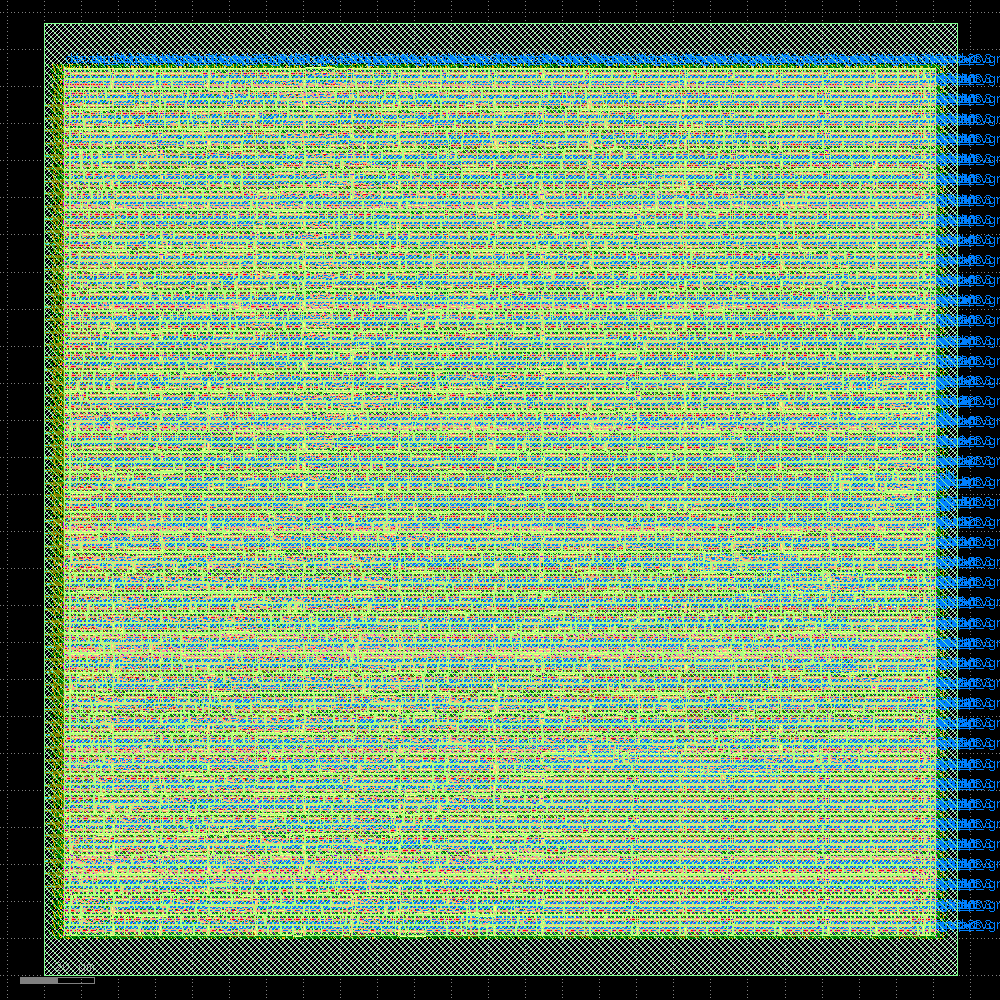

In [14]:
#@title Run Flow
#@markdown Click the ▷ button to run the OpenLane2 Flow and generate a GDS of the retimed L2 Norm design
import openlane
import os
from openlane.config import Config
from openlane.steps import Step
from openlane.state import State
import openlane.logging

openlane.logging.set_log_level("CRITICAL")
### Make Changes here ###
cwd_path = os.getcwd()
## Design Modules


top_module = ["top"]
design_paths = [f"{cwd_path}/../Design/Multiplier/array_multiplier.sv",
                 f"{cwd_path}/../Design/Divider/divider.sv",
                 f"{cwd_path}/../Design/AdderTree/AdderTree.sv",
                 f"{cwd_path}/../Design/SquareRoot/squareroot.sv",
                 f"{cwd_path}/../Design/Top/top.sv"]


## Library Modules
lib_modules = ["pipeline_stage"]
lib_paths = [f"{cwd_path}/../Design/lib/{lib_module}.sv" for lib_module in lib_modules]

FILES = [path for path in design_paths + lib_paths if path]

Config.interactive(
    "top",
    PDK="sky130A",
    CLOCK_PORT="clk",
    CLOCK_NET="clk",
    CLOCK_PERIOD=16,
    PRIMARY_GDSII_STREAMOUT_TOOL="klayout",
)

Synthesis = Step.factory.get("Yosys.Synthesis")

# Synthrsis step is different but lets see
synthesis = Synthesis(
    VERILOG_FILES=FILES,
    SYNTH_STRATEGY="DELAY 1",
    SYNTH_ABC_BUFFERING=True,            # Enable cell buffering
    state_in=State(),
)
synthesis.start()

Floorplan = Step.factory.get("OpenROAD.Floorplan")

floorplan = Floorplan(state_in=synthesis.state_out)
floorplan.start()
TapEndcapInsertion = Step.factory.get("OpenROAD.TapEndcapInsertion")

tdi = TapEndcapInsertion(state_in=floorplan.state_out)
tdi.start()

IOPlacement = Step.factory.get("OpenROAD.IOPlacement")

ioplace = IOPlacement(state_in=tdi.state_out)
ioplace.start()

GeneratePDN = Step.factory.get("OpenROAD.GeneratePDN")

pdn = GeneratePDN(
    state_in=ioplace.state_out,
    FP_PDN_VWIDTH=2,
    FP_PDN_HWIDTH=2,
    FP_PDN_VPITCH=30,
    FP_PDN_HPITCH=30,
)
pdn.start()

GlobalPlacement = Step.factory.get("OpenROAD.GlobalPlacement")

gpl = GlobalPlacement(state_in=pdn.state_out)
gpl.start()

DetailedPlacement = Step.factory.get("OpenROAD.DetailedPlacement")

dpl = DetailedPlacement(state_in=gpl.state_out)
dpl.start()

CTS = Step.factory.get("OpenROAD.CTS")

cts = CTS(state_in=dpl.state_out)
cts.start()

GlobalRouting = Step.factory.get("OpenROAD.GlobalRouting")

grt = GlobalRouting(state_in=cts.state_out)
grt.start()


DetailedRouting = Step.factory.get("OpenROAD.DetailedRouting")

drt = DetailedRouting(state_in=grt.state_out)
drt.start()

FillInsertion = Step.factory.get("OpenROAD.FillInsertion")

fill = FillInsertion(state_in=drt.state_out)
fill.start()

RCX = Step.factory.get("OpenROAD.RCX")

rcx = RCX(state_in=fill.state_out)
rcx.start()

STAPostPNR = Step.factory.get("OpenROAD.STAPostPNR")

sta_post_pnr = STAPostPNR(state_in=rcx.state_out)
sta_post_pnr.start()

StreamOut = Step.factory.get("KLayout.StreamOut")

gds = StreamOut(state_in=sta_post_pnr.state_out)
gds.start()

display(gds)